# 1. TEDA (Typicality & Eccentricity Data Analysis) — Bootcamp Notebook

Neste notebook contém um passo a passo para aplicar o **TEDA** em séries temporais de energia annotadas (LEAD 1.0).

Vamos abordar os seguintes tópicos:
1) carregamento e preparação dos dados;  
2) execução do TEDA (offline) com diferentes sensibilidades;  
3) comparação com rótulos de anomalia;  
4) visualizações (série temporal + sensibilidade ao parâmetro *m* + matriz de confusão).

> **Dica**: Execute as células na ordem. Os gráficos e CSVs são salvos no diretório atual.

## ⚙️ Requisitos

- Python 3.x  
- Bibliotecas: `pandas`, `numpy`, `matplotlib`, `scikit-learn`  
- Arquivos na mesma pasta do notebook:  
  - `lead1.0-small.csv`  
  - `teda.py` (contendo a classe `TEDA(threshold)` com `.run_offline(df, features)`)

> Se estiver em um ambiente novo, instale dependências:  
> `pip install pandas numpy matplotlib scikit-learn`

## Classes dos Códigos

In [1]:
import numpy as np


class TEDA:
    """Class used to detect outliers on the dataset"""
    # ------------------------------
    # CONSTRUCTOR
    #-------------------------------
    def __init__(self, threshold):
        # initialize variables
        self.k = 1
        self.variance = 0
        self.mean = 0
        self.threshold = threshold

    # ------------------------------
    # INTERNAL METHODS
    #-------------------------------
    def __calcMean(self, x):
        return ((self.k-1)/self.k)*self.mean + (1/self.k)*x

    def __calcVariance(self, x):
        distance_squared = np.square(np.linalg.norm(x - self.mean))
        return ((self.k-1)/self.k)*self.variance + distance_squared*(1/(self.k - 1))

    def __calcEccentricity(self, x):
        if(self.variance == 0):
            self.variance = 0.00001

        if (isinstance(x, float)):
            return (1 / self.k) +  (((self.mean - x)*(self.mean - x)) / (self.k *  self.variance))
        else:
            return (1 / self.k) +  (((self.mean - x).T.dot((self.mean - x))) / (self.k *  self.variance))



    # ------------------------------
    # RUN METHODS
    #-------------------------------
    def run_offline(self, df, features):
        """Run the algorithm offline"""

        # add is_outlier column to the dataframe
        df['is_outlier'] = 0

        # loop through the rows in df
        for index, row in df.iterrows():
            # build the X sample numpy array
            x = np.array(row[features])

            # update the model metrics
            if(self.k == 1):
                self.mean = x
                self.variance = 0
            else:
                # calculate the new mean
                self.mean = self.__calcMean(x)
                # calculate the new variance
                self.variance = self.__calcVariance(x)
                # calculate the eccentricity and normalized eccentricity
                eccentricity = self.__calcEccentricity(x)
                norm_eccentricity = eccentricity/2
                # define the threshold for outlier detection
                threshold_ = (self.threshold**2 +1)/(2*self.k)

                # check if the point is an outlier
                isOutlier = norm_eccentricity > threshold_

                # if the point is an outlier, add it to the outlier list
                if (isOutlier):
                    df.at[index, 'is_outlier'] = 1

            # Update the timestamp
            self.k = self.k + 1


    def run(self, x):
        "Run the algorithm online"""

        is_outlier = 0

        # update the model metrics
        if(self.k == 1):
            self.mean = x
            self.variance = 0
            #is_outlier = 1
        else:
            # calculate the new mean
            self.mean = self.__calcMean(x)
            # calculate the new variance
            self.variance = self.__calcVariance(x)
            # calculate the eccentricity and nomalized eccentricity
            eccentricity = self.__calcEccentricity(x)
            norm_eccentricity = eccentricity/2
            # define the threshold for outlier detection
            threshold_ = (self.threshold**2 +1)/(2*self.k)

            # check if the point is an outlier
            isOutlier = norm_eccentricity > threshold_

            # if the sample is an outlier, add it to the outlier list
            if (isOutlier):
                is_outlier = 1

        # Update the timestamp
        self.k = self.k + 1

        return is_outlier

In [2]:
import numpy as np

class RLSFilter:
    """
    Adaptive RLS filter.

    **Args:**

    * `n` : length of filter (integer) - how many input is input array
      (row of input matrix)

    **Kwargs:**

    * `mu` : forgetting factor (float). It is introduced to give exponentially
      less weight to older error samples. It is usually chosen
      between 0.98 and 1.

    * `delta` : regularization factor (float). It is usually chosen
      between 0.1 and 1.

    * `w` : initial weights of filter. Possible values are:

        * array with initial weights (1 dimensional array) of filter size

        * "zeros" : create zero value weights
    """

    def __init__(self, n=2, mu=0.99, delta=0.1, w=np.zeros(2)):
        if type(n) == int:
            self.n = n
        else:
            raise ValueError('The size of filter must be an integer')

        if ((mu <= 0) or (mu > 1)):
            raise ValueError('The forgetting factor must be between 0 an 1')
        else:
            self.mu = mu

        self.delta = delta
        self.w = w


        self.P = 1/self.delta * np.identity(n)
        self.dw = np.zeros(len(self.w))

    def update(self, d, x):
        """
        Update filter - adapting weights according to desired value and its input.

        **Args:**

        * `d` : desired value (float)

        * `x` : input array (1-dimensional array)
        """
        y = np.dot(self.w, x)
        e = d - y
        P1 = np.dot(np.dot(np.dot(self.P,x),x.T),self.P)
        P2 = self.mu + np.dot(np.dot(x,self.P),x.T)
        self.P = 1/self.mu * (self.P - P1/P2)
        self.dw = np.dot(self.P, x.T) * e
        self.w += self.dw

    def filter(self, x):
        """
        This function calculates the new output value `y` from input array `x`.

        **Args:**

        * `x` : input vector (1 dimension array) in length of filter.

        **Returns:**

        * `y` : output value (float) calculated from input array.

        """
        y = np.dot(self.w, x)
        return y

## 🔧 Parâmetros (edite aqui)

Escolha **prédio**, **janela temporal** e a **sensibilidade** do TEDA.  
Para a aula, você pode começar com um dos prédios/janelas sugeridos e variar `M_DEFAULT` e a lista `MS`.

> Quanto maior o `M_DEFAULT`, menos anomalias serão detectadas.

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Parâmetros principais
BUILDING_ID = 263
START = "2016-01-16 00:00:00"
END   = "2016-01-18 23:59:59"

# Sensibilidade do TEDA
M_DEFAULT = 0.15
MS = [0.05, 0.10, 0.15, 0.20, 0.25]

# Arquivos
DATA_PATH = "./lead1.0-small.csv"

print(f"Config: building={BUILDING_ID}, window=({START} → {END}), m0={M_DEFAULT}, sweep={MS}")


Config: building=263, window=(2016-01-16 00:00:00 → 2016-01-18 23:59:59), m0=0.15, sweep=[0.05, 0.1, 0.15, 0.2, 0.25]


## 📥 Carregar dados e filtrar janela
- Convertemos `timestamp` para `datetime`.
- Filtramos pelo `BUILDING_ID` e pela janela `[START, END]`.

In [4]:

# 1) Carregar dados
df = pd.read_csv(DATA_PATH)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Filtrar prédio e janela
mask = (
    (df["building_id"] == BUILDING_ID) &
    (df["timestamp"] >= pd.to_datetime(START)) &
    (df["timestamp"] <= pd.to_datetime(END))
)
df1 = df.loc[mask].copy()

print(df1.head())
print("Shape:", df1.shape)


       building_id           timestamp  meter_reading  anomaly
71531          263 2016-01-16 00:00:00          56.44        1
71731          263 2016-01-16 01:00:00          56.32        1
71930          263 2016-01-16 02:00:00          57.08        1
72130          263 2016-01-16 03:00:00          55.82        1
72330          263 2016-01-16 04:00:00          53.69        1
Shape: (72, 4)


## 🧠 Importar o TEDA
O arquivo `teda.py` deve estar no mesmo diretório. Ele precisa expor a classe `TEDA(threshold)` com o método `run_offline(df, features)`.

In [7]:
# Função utilitária para aplicar o TEDA
def apply_teda(g: pd.DataFrame, m: float) -> pd.DataFrame:
    g = g.sort_values("timestamp").reset_index(drop=True)
    work = g[["meter_reading"]].copy()
    model = TEDA(threshold=m)
    model.run_offline(work, features=["meter_reading"])  # adiciona coluna 'is_outlier'
    g = g.copy()
    g["teda_outlier"] = work["is_outlier"].astype(int).values
    return g


## ▶️ Rodar TEDA (m = `M_DEFAULT`)
Calculamos também as métricas contra o rótulo `anomaly`.

In [9]:

# 4) Rodar TEDA (m = M_DEFAULT)
res = apply_teda(df1, m=M_DEFAULT)

# 5) Métricas
y_true = res["anomaly"].astype(int).values
y_pred = res["teda_outlier"].astype(int).values
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print(f"[Prédio {BUILDING_ID} | {START} → {END} | m={M_DEFAULT}]")
print(f"Precisão={prec:.3f}  Revocação={rec:.3f}  F1={f1:.3f}")


[Prédio 263 | 2016-01-16 00:00:00 → 2016-01-18 23:59:59 | m=0.15]
Precisão=1.000  Revocação=0.944  F1=0.971


## 🧩 Matriz de confusão (m = `M_DEFAULT`)
Ajuda a interpretar o trade-off entre falsos positivos e falsos negativos.

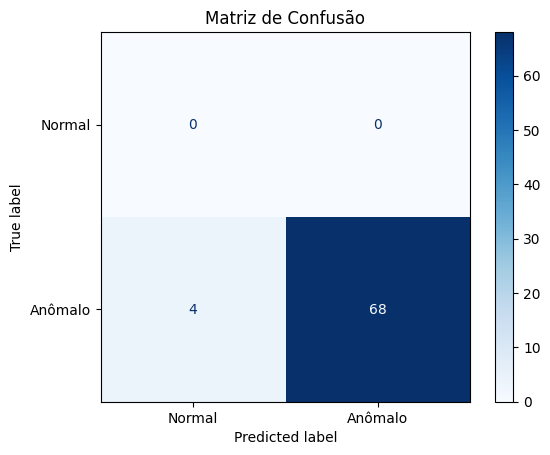

In [10]:
# plotar matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Normal", "Anômalo"])
disp.plot(values_format="d", cmap="Blues", colorbar=True)
plt.title("Matriz de Confusão")
plt.grid(False)
plt.show()

## 📈 Série temporal com rótulos e detecções do TEDA
Marcamos os rótulos (`anomaly=1`) e as detecções do TEDA.

<function matplotlib.pyplot.show(close=None, block=None)>

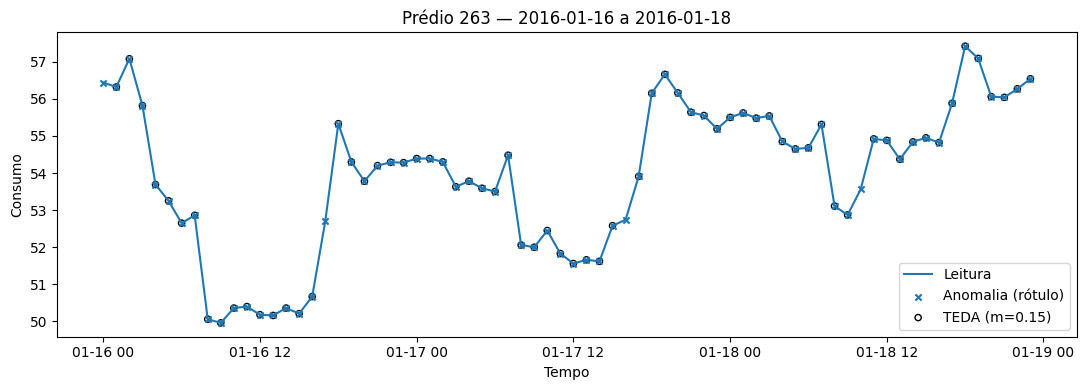

In [11]:

# 6) Série temporal
plt.figure(figsize=(11,4))
plt.plot(res["timestamp"], res["meter_reading"], label="Leitura")
plt.scatter(res.loc[res["anomaly"]==1, "timestamp"], res.loc[res["anomaly"]==1, "meter_reading"],
            marker="x", s=20, label="Anomalia (rótulo)", zorder=3)
plt.scatter(res.loc[res["teda_outlier"]==1, "timestamp"], res.loc[res["teda_outlier"]==1, "meter_reading"],
            facecolors="none", edgecolors="k", s=20, label=f"TEDA (m={M_DEFAULT})")
plt.title(f"Prédio {BUILDING_ID} — {START[:10]} a {END[:10]}")
plt.xlabel("Tempo"); plt.ylabel("Consumo")
plt.legend(); plt.tight_layout()
# plt.savefig(f"./serie_{BUILDING_ID}.png", dpi=180); plt.close()
# print("Figura salva:", f"./serie_{BUILDING_ID}.png")
plt.show

Sensibilidade ao m:
       m  precision    recall        f1
0  0.05        1.0  0.972222  0.985915
1  0.10        1.0  0.958333  0.978723
2  0.15        1.0  0.944444  0.971429
3  0.20        1.0  0.916667  0.956522
4  0.25        1.0  0.888889  0.941176


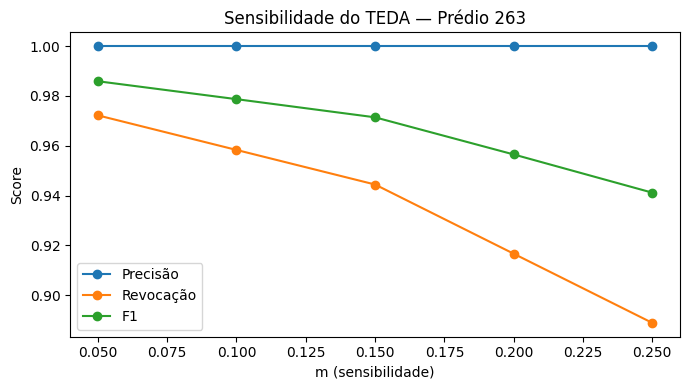

In [12]:
# 7) Sensibilidade ao m
mask = (
    (df["building_id"] == BUILDING_ID) &
    (df["timestamp"] >= pd.to_datetime(START)) &
    (df["timestamp"] <= pd.to_datetime(END))
)
df1 = df.loc[mask].copy()

rows = []
for m in MS:
    tmp = apply_teda(df1, m=m)
    p_i, r_i, f1_i, _ = precision_recall_fscore_support(
        tmp["anomaly"].astype(int).values,
        tmp["teda_outlier"].astype(int).values,
        average="binary", zero_division=0
    )
    rows.append((m, p_i, r_i, f1_i))

scores = pd.DataFrame(rows, columns=["m","precision","recall","f1"])
print("Sensibilidade ao m:\n", scores)

plt.figure(figsize=(7,4))
plt.plot(scores["m"], scores["precision"], marker="o", label="Precisão")
plt.plot(scores["m"], scores["recall"], marker="o", label="Revocação")
plt.plot(scores["m"], scores["f1"], marker="o", label="F1")
plt.xlabel("m (sensibilidade)"); plt.ylabel("Score")
plt.title(f"Sensibilidade do TEDA — Prédio {BUILDING_ID}")
plt.legend(); plt.tight_layout()
# plt.savefig(f"./sens_m_{BUILDING_ID}.png", dpi=180); plt.close()
# print("Figura salva:", f"./sens_m_{BUILDING_ID}.png")
plt.show()

## 💾 Salvar resultados por amostra
Inclui a coluna `teda_outlier` para análise posterior.

In [13]:

# 9) Salvar CSV
res.to_csv(f"./teda_results_{BUILDING_ID}_{START[:10]}_{END[:10]}.csv", index=False)
print("CSV salvo:", f"./teda_results_{BUILDING_ID}_{START[:10]}_{END[:10]}.csv")


CSV salvo: ./teda_results_263_2016-01-16_2016-01-18.csv


---

## 🔎 (Opcional) Descobrir automaticamente boas janelas para demonstração
Encontra janelas de 3 dias com **anomalias e variação** (evita séries “retas”). Edite os limiares para refinar.

In [14]:

WINDOW_DAYS = 3
MIN_ANOMS   = 3
MIN_CV      = 0.02
MIN_UNIQUE  = 0.15

df_all = pd.read_csv(DATA_PATH)
df_all["timestamp"] = pd.to_datetime(df_all["timestamp"])
df_all = df_all.sort_values(["building_id","timestamp"])

def scan_building(df_b, window_days=WINDOW_DAYS):
    out = []
    days = pd.date_range(df_b["timestamp"].min().normalize(),
                         df_b["timestamp"].max().normalize(), freq="D")
    for start in days:
        end = start + pd.Timedelta(days=window_days) - pd.Timedelta(seconds=1)
        sel = (df_b["timestamp"] >= start) & (df_b["timestamp"] <= end)
        chunk = df_b.loc[sel].copy()
        if len(chunk) < 24:
            continue
        chunk = chunk.set_index("timestamp")
        chunk["meter_reading"] = chunk["meter_reading"].interpolate(method="time", limit_direction="both")
        chunk = chunk.reset_index()
        vals = chunk["meter_reading"].dropna().values
        if len(vals) == 0:
            continue
        mean = float(np.mean(vals))
        std  = float(np.std(vals))
        cv   = (std/mean) if mean != 0 else (np.inf if std>0 else 0.0)
        unique_ratio = pd.Series(vals).nunique() / len(vals)
        anoms = int(chunk["anomaly"].sum())
        if (anoms >= MIN_ANOMS) and (cv >= MIN_CV) and (unique_ratio >= MIN_UNIQUE):
            out.append({
                "building_id": int(df_b["building_id"].iloc[0]),
                "start": start, "end": end,
                "n_points": int(len(vals)),
                "anoms": anoms,
                "cv": round(cv, 4),
                "unique_ratio": round(unique_ratio, 3)
            })
    return out

anom_blds = df_all.loc[df_all["anomaly"]==1, "building_id"].unique().tolist()
cands = []
for b in anom_blds:
    cands.extend(scan_building(df_all[df_all["building_id"]==b].copy()))

cands = pd.DataFrame(cands).sort_values(["anoms","cv","unique_ratio"], ascending=[False, False, False]).reset_index(drop=True)
print("Top 10 janelas:")
cands.head(10)


Top 10 janelas:


,building_id,start,end,n_points,anoms,cv,unique_ratio
0,141,2016-12-27,2016-12-29 23:59:59,72,72,0.1428,0.514
1,190,2016-09-23,2016-09-25 23:59:59,72,72,0.0612,0.903
2,263,2016-01-16,2016-01-18 23:59:59,72,72,0.0366,0.944
3,254,2016-10-21,2016-10-23 23:59:59,72,69,1.3138,0.569
4,141,2016-12-28,2016-12-30 23:59:59,72,68,0.1427,0.583
5,653,2016-02-15,2016-02-17 23:59:59,72,68,0.1382,1.000
6,439,2016-12-24,2016-12-26 23:59:59,72,68,0.0591,1.000
7,1353,2016-11-23,2016-11-25 23:59:59,72,66,0.1898,0.639
8,1309,2016-07-17,2016-07-19 23:59:59,72,65,0.5202,0.222
9,190,2016-09-22,2016-09-24 23:59:59,72,65,0.3407,0.944



---

# 🏃 Exercícios rápidos

Use esta seção para praticar ajustes do TEDA, comparar prédios e investigar erros.  
**Dica:** execute as células anteriores primeiro (até gerar `apply_teda`, `df`, `BUILDING_ID`, etc.).



## 1) Ajuste fino do `m` (sensibilidade)
Altere `M_DEFAULT` e reavalie rapidamente as métricas para o mesmo prédio e janela.


In [15]:

# TODO: ajuste aqui e rode
M_TRY = 0.08  # experimente: 0.03, 0.05, 0.08, 0.12, ...

mask = (
    (df["building_id"] == BUILDING_ID) &
    (df["timestamp"] >= pd.to_datetime(START)) &
    (df["timestamp"] <= pd.to_datetime(END))
)

df_try = df.loc[mask].copy()

res_try = apply_teda(df_try, m=M_TRY)
y_true = res_try["anomaly"].astype(int).values
y_pred = res_try["teda_outlier"].astype(int).values

prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
print(f"[m={M_TRY}] Precisão={prec:.3f} | Revocação={rec:.3f} | F1={f1:.3f}")


[m=0.08] Precisão=1.000 | Revocação=0.972 | F1=0.986


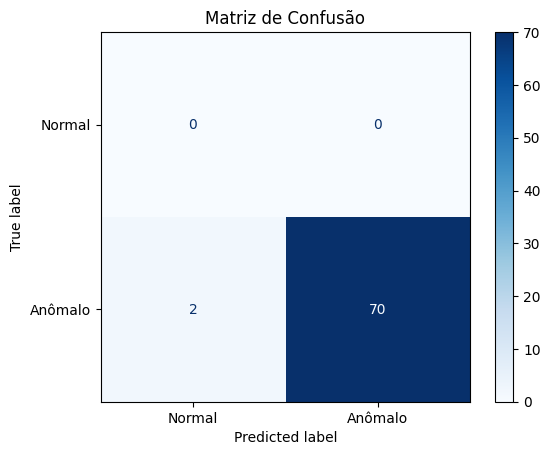

In [16]:
# plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Normal", "Anômalo"])
disp.plot(values_format="d", cmap="Blues", colorbar=True)
plt.title("Matriz de Confusão")
plt.grid(False)
plt.show()


## 2) Busca de `m` ótimo por F1 (grid simples)
Varra vários valores de `m` e escolha o melhor por F1 para **este prédio/janela**.


In [17]:

m_grid = np.linspace(0.02, 0.20, 13)  # 0.02, 0.04, ..., 0.20
rows = []
for m in m_grid:
    tmp = apply_teda(df1, m=float(m))
    p_i, r_i, f1_i, _ = precision_recall_fscore_support(
        tmp["anomaly"].astype(int).values,
        tmp["teda_outlier"].astype(int).values,
        average="binary",
        zero_division=0
    )
    rows.append((float(m), p_i, r_i, f1_i))
grid_scores = pd.DataFrame(rows, columns=["m","precision","recall","f1"]).sort_values("f1", ascending=False)
grid_scores.head(10)

,m,precision,recall,f1
0,0.020,1.0,0.972222,0.985915
1,0.035,1.0,0.972222,0.985915
2,0.050,1.0,0.972222,0.985915
3,0.065,1.0,0.972222,0.985915
4,0.080,1.0,0.972222,0.985915
5,0.095,1.0,0.972222,0.985915
6,0.110,1.0,0.958333,0.978723
7,0.125,1.0,0.944444,0.971429
8,0.140,1.0,0.944444,0.971429
9,0.155,1.0,0.944444,0.971429



## 3) Comparar dois prédios
Escolha um **segundo prédio** com a respectiva janela de tempo e compare métricas/curvas.


| building_id | start       | end                  | n_points | anoms |    cv   | unique_ratio |
|-------------|-------------|----------------------|----------|-------|---------|--------------|
| 141         | 2016-12-27  | 2016-12-29 23:59:59   | 72       | 72    | 0.1428  | 0.514        |
| 190         | 2016-09-23  | 2016-09-25 23:59:59   | 72       | 72    | 0.0612  | 0.903        |
| 263         | 2016-01-16  | 2016-01-18 23:59:59   | 72       | 72    | 0.0366  | 0.944        |
| 254         | 2016-10-21  | 2016-10-23 23:59:59   | 72       | 69    | 1.3138  | 0.569        |
| 141         | 2016-12-28  | 2016-12-30 23:59:59   | 72       | 68    | 0.1427  | 0.583        |
| 653         | 2016-02-15  | 2016-02-17 23:59:59   | 72       | 68    | 0.1382  | 1.000        |
| 439         | 2016-12-24  | 2016-12-26 23:59:59   | 72       | 68    | 0.0591  | 1.000        |
| 1353        | 2016-11-23  | 2016-11-25 23:59:59   | 72       | 66    | 0.1898  | 0.639        |
| 1309        | 2016-07-17  | 2016-07-19 23:59:59   | 72       | 65    | 0.5202  | 0.222        |
| 190         | 2016-09-22  | 2016-09-24 23:59:59   | 72       | 65    | 0.3407  | 0.944        |

In [18]:

# TODO: escolha um prédio 2 com anomalias na mesma janela START–END
BUILDING_ID_2 = BUILDING_ID  # troque para outro ID (Vejam a tabela)
START = START
END = END

# df = pd.read_csv(DATA_PATH)
# df["timestamp"] = pd.to_datetime(df["timestamp"])

# Filtrar o segundo prédio
mask2 = (
    (df["building_id"] == BUILDING_ID_2) &
    (df["timestamp"] >= pd.to_datetime(START)) &
    (df["timestamp"] <= pd.to_datetime(END))
)

df2 = df.loc[mask2].copy().sort_values("timestamp")
df2 = df2.reset_index()

# Rodar TEDA em ambos com o mesmo m
res1 = apply_teda(df1,  m=M_DEFAULT)    # prédio 1 (já filtrado anteriormente)
res2 = apply_teda(df2, m=M_DEFAULT)    # prédio 2

def metrics_of(res):
    y_true = res["anomaly"].astype(int).values
    y_pred = res["teda_outlier"].astype(int).values
    return precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)[:3]

p1, r1, f1 = metrics_of(res1)
p2, r2, f2 = metrics_of(res2)

print(f"Prédio {BUILDING_ID}:  P={p1:.3f} R={r1:.3f} F1={f1:.3f}")
print(f"Prédio {BUILDING_ID_2}: P={p2:.3f} R={r2:.3f} F1={f2:.3f}")


Prédio 263:  P=1.000 R=0.944 F1=0.971
Prédio 263: P=1.000 R=0.944 F1=0.971



## 4) Investigue **FP** e **FN**
Liste timestamps onde o TEDA aponta outlier mas o rótulo é 0 (FP) e onde o rótulo é 1 mas o TEDA não detecta (FN).


In [19]:

res_dbg = res.copy()
res_dbg["FP"] = ((res_dbg["teda_outlier"]==1) & (res_dbg["anomaly"]==0)).astype(int)
res_dbg["FN"] = ((res_dbg["teda_outlier"]==0) & (res_dbg["anomaly"]==1)).astype(int)

print("Falsos positivos (primeiros 10):")
display(res_dbg.loc[res_dbg["FP"]==1, ["timestamp","meter_reading","anomaly","teda_outlier"]].head(10))

print("Falsos negativos (primeiros 10):")
display(res_dbg.loc[res_dbg["FN"]==1, ["timestamp","meter_reading","anomaly","teda_outlier"]].head(10))


Falsos positivos (primeiros 10):


,timestamp,meter_reading,anomaly,teda_outlier


Falsos negativos (primeiros 10):


,timestamp,meter_reading,anomaly,teda_outlier
0,2016-01-16 00:00:00,56.44,1,0
17,2016-01-16 17:00:00,52.70,1,0
40,2016-01-17 16:00:00,52.74,1,0
58,2016-01-18 10:00:00,53.56,1,0


# 🧠 TEDA-RLS: Integração do TEDA com o Filtro RLS

Nesta seção, vamos explorar como o **TEDA (Typicality and Eccentricity Data Analytics)**
pode ser combinado com o **Filtro de Mínimos Quadrados Recursivos (RLS)**.

- O **TEDA** é usado para detectar anomalias em fluxos de dados.
- O **RLS** é usado para ajustar parâmetros de forma recursiva em problemas de regressão.
- A junção dos dois permite **detectar e corrigir anomalias em tempo real**.


### 📌 Ideia principal

1. O **TEDA** identifica se a nova amostra é **típica** ou **excêntrica**.
2. Se for típica, a atualização do modelo segue normalmente pelo **RLS**.
3. Se for excêntrica (potencial outlier):
   - O RLS pode ser atualizado com menor peso;
   - Ou a amostra pode ser descartada.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from random import randint, sample

## 📥 Carregar dados

Utilizaremos um conjunto de dados modificado, visto que foi obtido de uma subestação de distribuição simulada. Os dados simulados são baseados no sistema de supervisão SCADA, que adquiriu o valor da potência ativa do alimentador (MW) a cada 15 minutos, totalizando 96 medições em um dia. No conjunto de dados a seguir, teremos 10 dias consecutivos.

In [22]:
# Leitura dos dados
data = pd.read_excel("PowerWithOutliers.xlsx")
data.head()

print(data.head())

        Date      Hour      P  label  P with outliers
0 2010-01-01  00:00:00  770.0      0            770.0
1 2010-01-01  00:15:00  754.0      0            754.0
2 2010-01-01  00:30:00  754.0      0            754.0
3 2010-01-01  00:45:00  724.0      0            724.0
4 2010-01-01  01:00:00  724.0      0            724.0


In [23]:
# Criação da série temporal
ts = np.linspace(0, len(data), len(data))

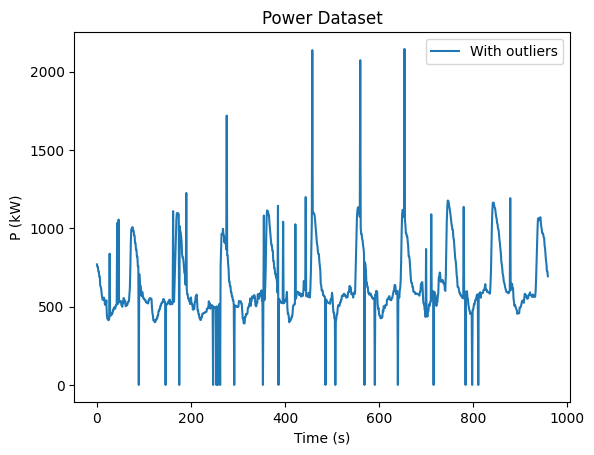

In [24]:
# Cria a figura e o eixo
fig, ax = plt.subplots()

# Plota as duas séries
ax.plot(data.index, data['P with outliers'], label="With outliers")

# Configurações dos eixos e título
ax.set_title("Power Dataset")
ax.set_xlabel("Time (s)")
ax.set_ylabel("P (kW)")

# Mostra a legenda
ax.legend()

# Exibe o gráfico
plt.show()

## 📐 Filtro RLS (Recursive Least Squares)

O **RLS** é um algoritmo recursivo para estimação de parâmetros em tempo real.  
Ele atualiza os **pesos do modelo** (θ) a cada nova amostra $(x_k, y_k)$,
usando o **fator de esquecimento** (λ) e a **matriz de covariância** (P).

### 🔹 Parâmetros definidos no código

- `filter_order` → dimensão do vetor de entrada $x_k$  
- `forgetting_factor` → $\lambda$, fator de esquecimento (0.98–1)  
- `regularization_factor` → $\delta$, usado na inicialização de $P_0$  
- `w0` → $\theta_0$, vetor inicial de parâmetros  
- `X_ant` → $x_0$, entrada inicial  

### 🔹 Variáveis internas do RLS (calculadas automaticamente)

- $K_k$ → **ganho de Kalman**, ajusta o peso da nova amostra (não é parâmetro fixo)  
- $\theta_k$ → vetor de parâmetros estimados (pesos do filtro)  
- $P_k$ → matriz de covariância, mede a incerteza nos parâmetros  

### 🔹 Equações do RLS

- **Ganho de Kalman:**
$$
K_k = \frac{P_{k-1}x_k}{\lambda + x_k^T P_{k-1} x_k}
$$

- **Atualização dos parâmetros:**
$$
\theta_k = \theta_{k-1} + K_k \big(y_k - x_k^T \theta_{k-1}\big)
$$

- **Atualização da matriz de covariância:**
$$
P_k = \frac{1}{\lambda}\Big(P_{k-1} - K_k x_k^T P_{k-1}\Big)
$$


In [30]:
## Definindo parâmetros

#TEDA
teda = TEDA(threshold=2.5)
correction = True   # Flag para correção de outliers consecutivos
N_outlier_max = 1   # Numero maximo de outliers corrigidos pelo TEDA-RLS
FLAG = []

#RLS
filter_order = 4               # ordem do filtro (dimensão do vetor x_k)
forgetting_factor = 0.999      # λ (fator de esquecimento)
regularization_factor = 0.1    # δ (fator de regularização inicial)
w0 = np.zeros(filter_order)    # θ_0 (pesos iniciais)
X_ant = np.zeros(filter_order) # x_0 (entrada inicial)
rls_filter = RLSFilter(n=filter_order, mu=forgetting_factor, delta=regularization_factor, w=w0)

In [31]:
# variáveis auxiliares
Ya_py = []          # Vetor de valores previstos auxiliares
Y_py = []           # Vetor de valores previstos
DB = []             # Vetor de valores salvos (banco de dados)
outlier_count = 0   # Contagem de outliers
y_pred_py = 0.0     # Valor previsto inicial

### 📌 Ideia principal

1. O **TEDA** identifica se a nova amostra é **típica** ou **excêntrica**.
2. Se for típica, a atualização do modelo segue normalmente pelo **RLS**.
3. Se for excêntrica (potencial outlier):
   - O RLS pode ser atualizado com menor peso;
   - Ou a amostra pode ser descartada.

### 🔄 Atualização recursiva no TEDA-RLS

O TEDA calcula **excentricidade** e **tipicidade** da nova amostra.  
Essas medidas são usadas para decidir **quanto a amostra deve influenciar** a atualização do RLS.

- **Excentricidade alta** → amostra pouco confiável.
- **Tipicidade alta** → amostra confiável.

Dessa forma, o RLS não é “contaminado” por outliers.

In [32]:
for i in data['P with outliers']:
    ## Pegando o dado de entrada
    valor_atual = i

    #Verificando se é um outlier
    flag = teda.run(valor_atual)
    FLAG.append(flag)

    ## Primeiro estágio: Correção de outlier
    if (flag == 1):
        outlier_count = outlier_count + 1
        valor_atual = y_pred_py
    else:
        outlier_count = 0

    #Avaliação da enxurrada de outliers
    if(correction == True and outlier_count == N_outlier_max + 1):
        valor_atual = i

    # Salvando
    Ya_py.append(y_pred_py)

    # Atualizando pesos
    rls_filter.update(valor_atual, np.array(X_ant))
    input_vector = []
    for j in X_ant[1:]:
        input_vector.append(j)
    input_vector.append(valor_atual)

    # Prevendo o próximo valor
    y_pred_py = rls_filter.filter(input_vector)
    Y_py.append(y_pred_py)

    # Segundo estágio
    if (flag == 1):
        valor_atual = y_pred_py

    if(correction == True and outlier_count == N_outlier_max + 1):
        outlier_count = 0
        valor_atual = i
    DB.append(valor_atual)

    #Atualizando vetor de valores anteriores
    X_ant = input_vector

data['flag_py'] = FLAG
#data['x_antp'] = data['x_ant']
data['save_py'] = DB
data['ya_pred_py'] = Ya_py
data['y_pred_py'] = Y_py

### 📊 Interpretação

- O TEDA-RLS combina **robustez contra anomalias** (TEDA)
  com **eficiência em regressão online** (RLS).
- Isso permite aplicações em:
  - Séries temporais ruidosas
  - Detecção de falhas
  - Dados veiculares em tempo real

In [33]:
def find_indices(list_to_check, item_to_find):
    """Encontrar todos os índices de um item em uma lista."""
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

numberOfOutliersPython = data['flag_py'].sum()
print("Quantidade de outliers detectados: ", numberOfOutliersPython)

Quantidade de outliers detectados:  42


In [34]:
outliersIndexPython = find_indices(data['flag_py'], 1)

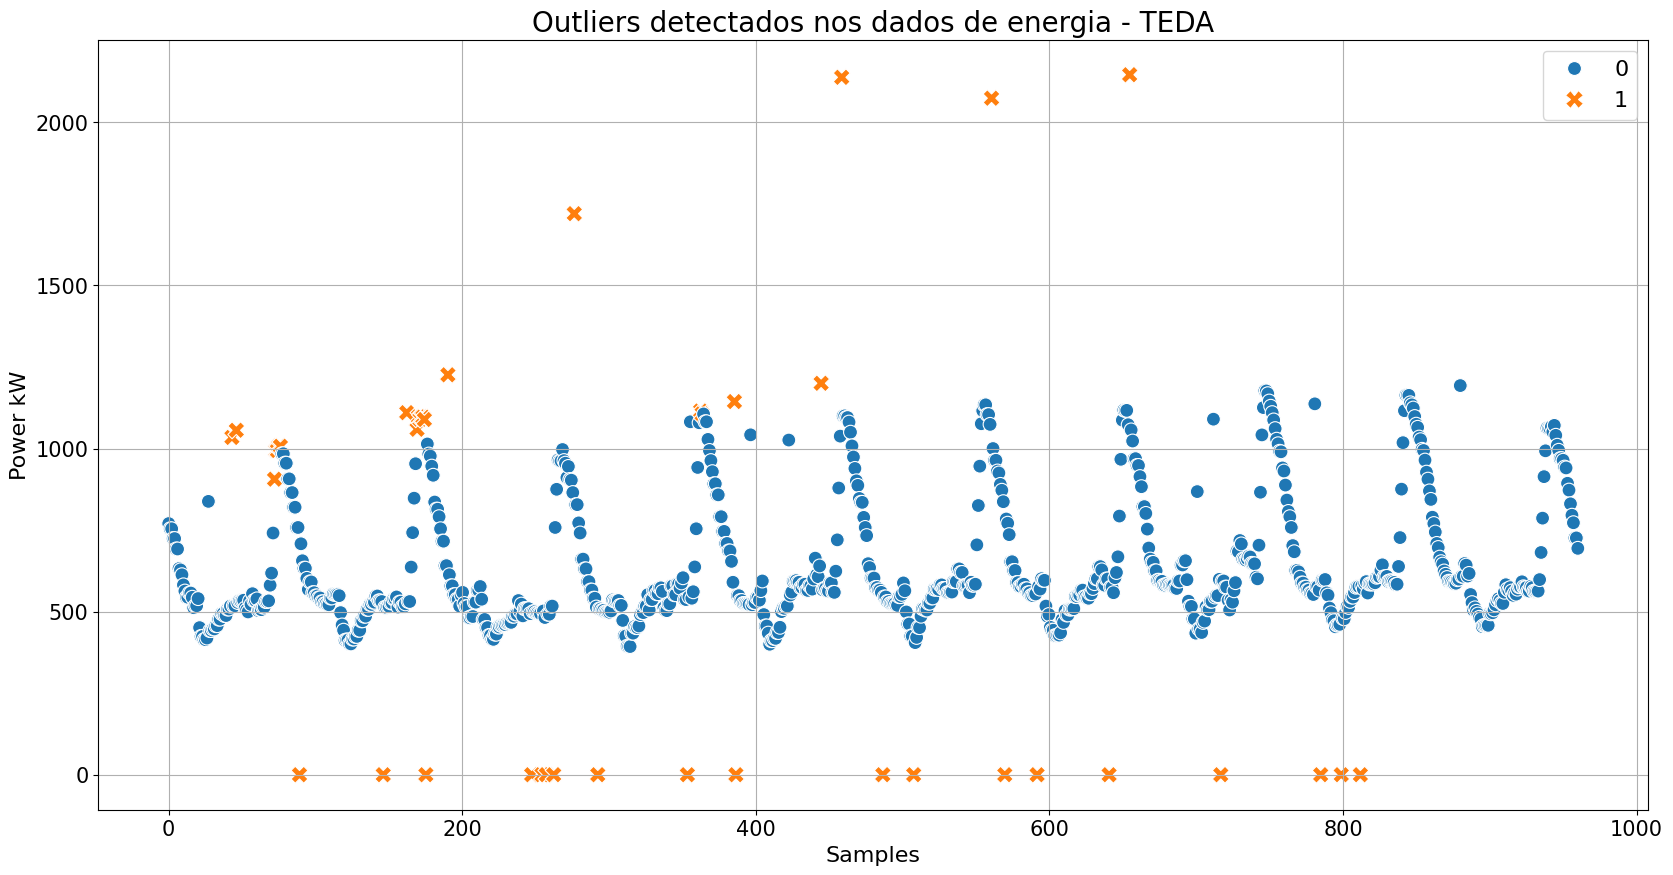

In [35]:
# Visualização dos resultados do TEDA
plt.figure(figsize=(20,10))
plt.grid()
plt.title("Outliers detectados nos dados de energia - TEDA", fontsize=20)
sns.scatterplot(x=ts, y=data['P with outliers'], hue=data['flag_py'], style=data['flag_py'], size=data['flag_py'], sizes=(150, 100))
plt.legend(fontsize=16)
plt.ylabel("Power kW", fontsize=16)
plt.xlabel("Samples", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

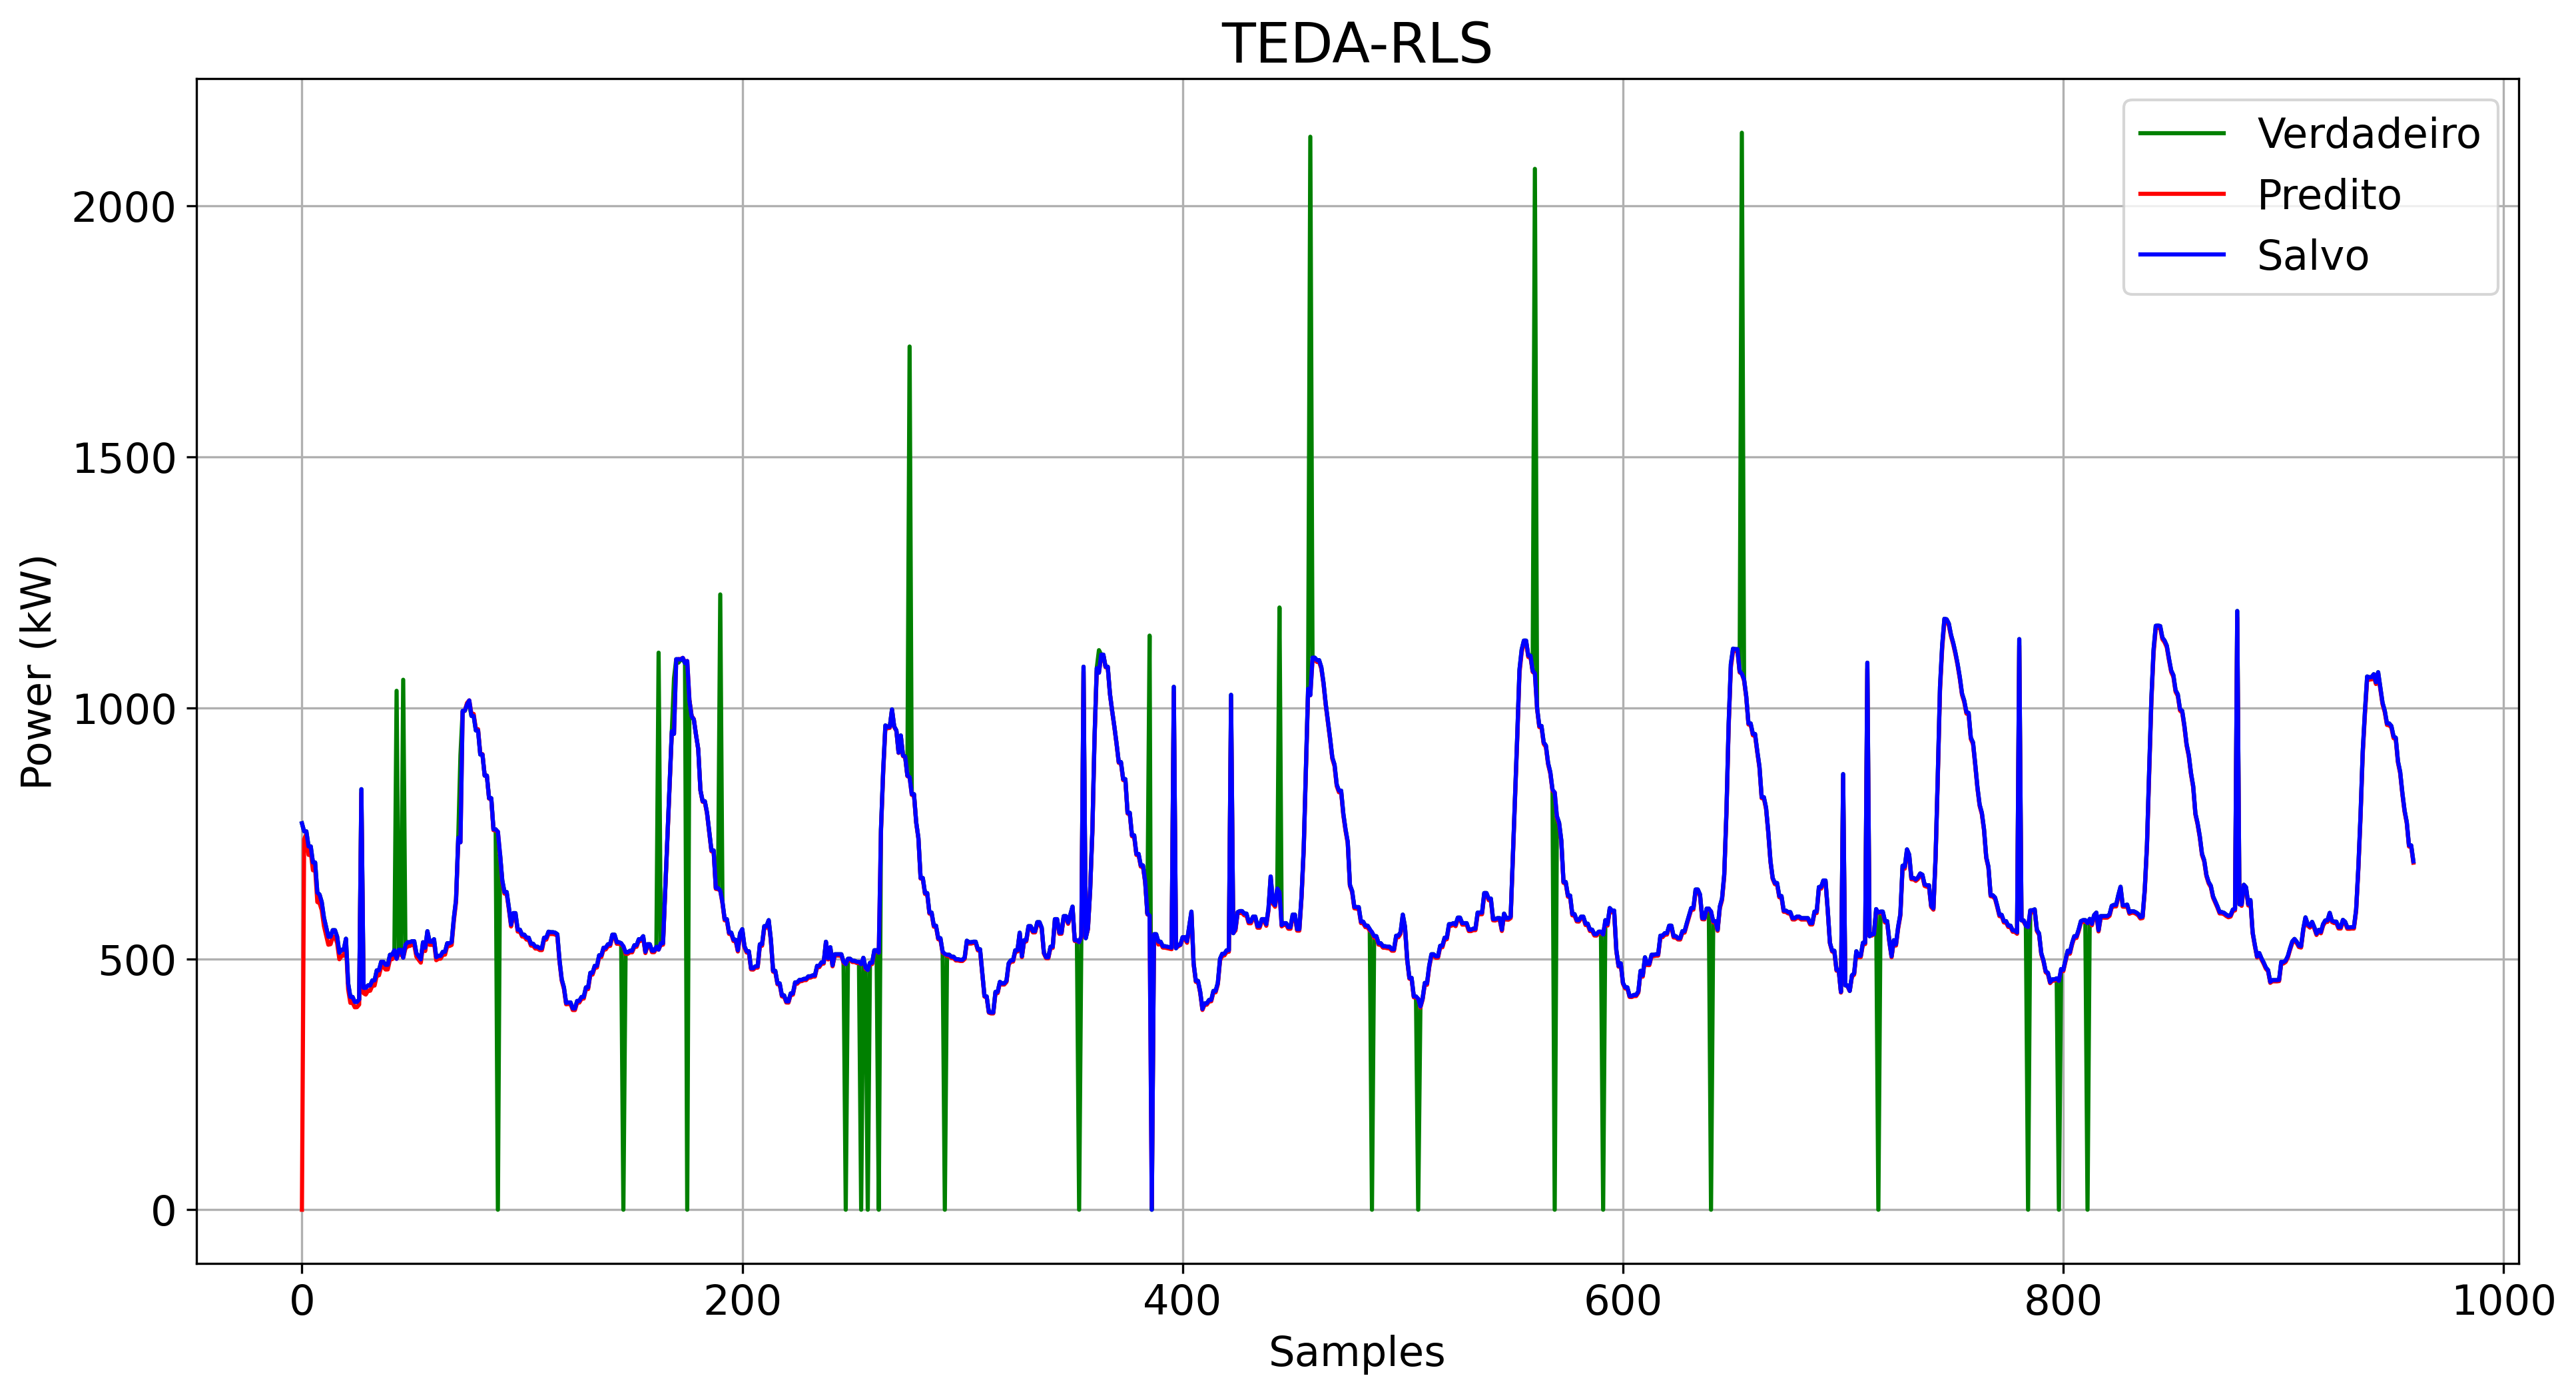

In [36]:
plt.figure(figsize=(15,7.7), dpi=300)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.xlabel("Samples", fontsize=15)
plt.ylabel("Power (kW)", fontsize=15)
plt.plot(data['P with outliers'], 'g', label='Verdadeiro')
plt.plot(data['y_pred_py'], 'r', label='Predito')
plt.plot(data['save_py'], 'b', label='Salvo')
plt.legend(fontsize=15)
plt.title("TEDA-RLS", fontsize=20)
plt.show()

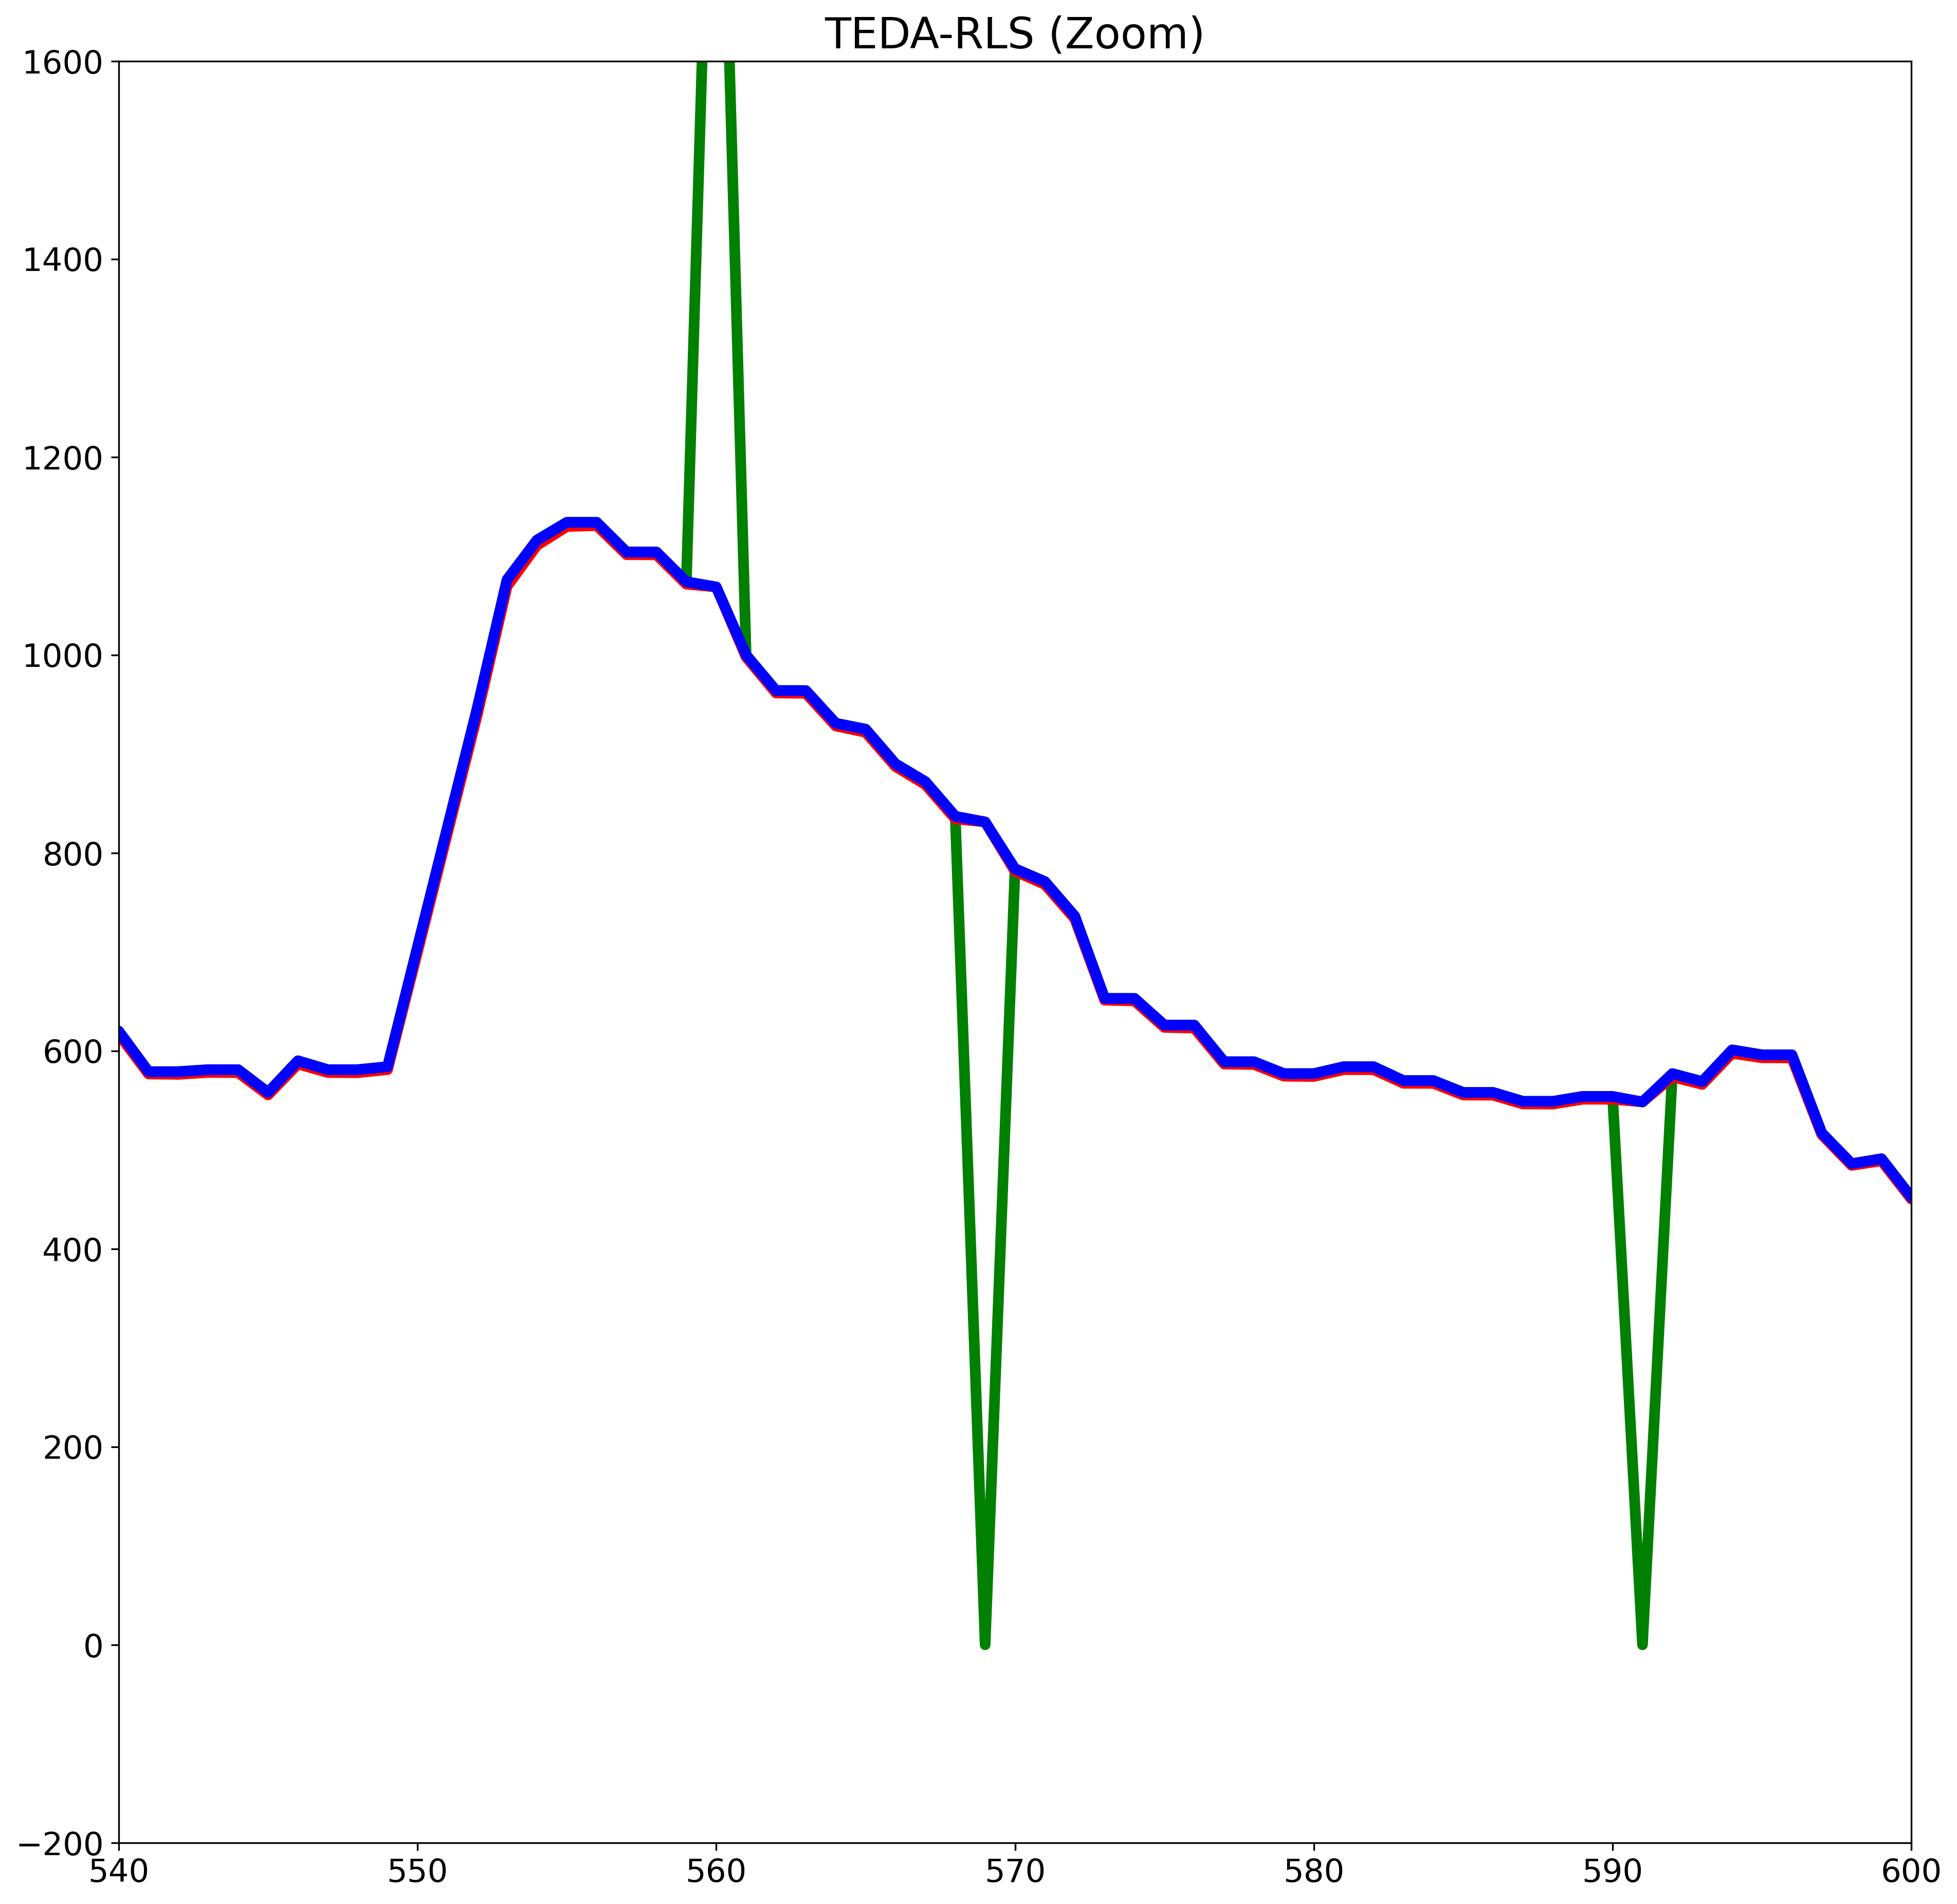

In [37]:
plt.figure(figsize=(15,15), dpi=300)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim((540, 600))
plt.ylim((-200, 1600))
plt.plot(data['P with outliers'], 'g', linewidth=5)
plt.plot(data['y_pred_py'], 'r', linewidth=5)
plt.plot(data['save_py'], 'b', linewidth=5)
plt.title("TEDA-RLS (Zoom)", fontsize=20)
plt.show()

## 📊 Métricas de Avaliação

Nesta seção, apresentamos as métricas utilizadas para avaliar os algoritmos:

- **TEDA (classificação):**
  - Avaliamos o desempenho do classificador na detecção de amostras típicas e excêntricas.
  - Usamos **relatório de classificação** (precisão, revocação, F1-score) e **matriz de confusão**.

- **RLS (regressão):**
  - Avaliamos a qualidade da previsão numérica feita pelo RLS.
  - Usamos métricas de erro, como o **Erro Quadrático Médio (MSE)** e o **Erro Absoluto Médio (MAE)**.

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error

### ⚖️ Métricas do TEDA

- **Matriz de Confusão:** mostra a quantidade de acertos e erros em cada classe (típica vs. excêntrica).
- **Relatório de Classificação:** inclui precisão, revocação e F1-score, que ajudam a entender se o modelo está
  - identificando bem as amostras típicas,
  - e não confundindo com excêntricas.

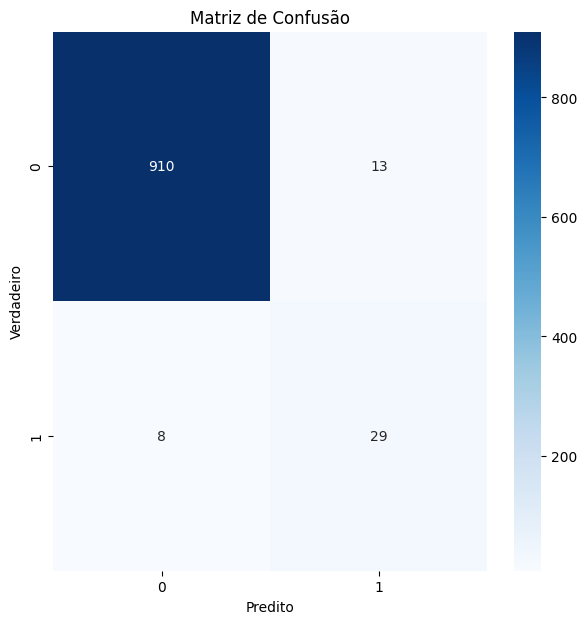

In [39]:
cm = confusion_matrix(data['label'], data['flag_py'])
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

In [40]:
print(classification_report(data['label'], data['flag_py']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       923
           1       0.69      0.78      0.73        37

    accuracy                           0.98       960
   macro avg       0.84      0.88      0.86       960
weighted avg       0.98      0.98      0.98       960



### 📐 Métricas do RLS

- **MSE (Erro Quadrático Médio):**
  $$
  \text{MSE} = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2
  $$

  Mede o erro médio ao quadrado → penaliza mais erros grandes.

- **MAE (Erro Absoluto Médio):**
  $$
  \text{MAE} = \frac{1}{N} \sum_{i=1}^N |y_i - \hat{y}_i|
  $$

  Mede o erro médio absoluto → mais interpretável e robusto contra grandes outliers.

In [41]:
start = 0

rmse_pred_py = mean_squared_error(data['P with outliers'].iloc[start:], data['y_pred_py'].iloc[start:])
mae_pred_py = mean_absolute_error(data['P with outliers'].iloc[start:], data['y_pred_py'].iloc[start:])
print("Mean Squared Error (RMSE) - RLS:", rmse_pred_py)
print("Mean Absolute Error (MAE) - RLS:", mae_pred_py)

Mean Squared Error (RMSE) - RLS: 13859.188959594232
Mean Absolute Error (MAE) - RLS: 23.15122318843618
